In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal, stats
import sys, os
sys.path.append('../')

from nlds.data_utils import load_mouse_data, return_pops
import nlds.delayembed as de
import pandas as pd
from sklearn.decomposition import PCA
import fooof
from fooof import FOOOFGroup
from seaborn import despine

from neurodsp.spectral import compute_spectrum

In [2]:
datafolder = '../../Neuropixel/'
 # '/Users/rdgao/Documents/data/Stringer_neuropixel/spikes/'
mice = ['Krebs', 'Waksman', 'Robbins']
feats = ['SU T Exp.', 'Pop. T Exp.', 'Pop. S Exp.', 'SSA Low Exp.','SSA High Exp.']

df_collect = []
val_regions = []
fr_all, pca_all, psd_all, ssa_all = [], [], [], []
for i_m in range(3):
    df_spk, df_info = load_mouse_data(datafolder, i_m, return_type='binned', bin_width=1)
    spk_list, region_labels = return_pops(df_spk, df_info)
    print(region_labels, [s.shape[1] for s in spk_list])
    fr_all.append([s.shape[1]/s.shape[0] for s in spk_list])

    su_start_ind = len(region_labels)+1

    ### PSD
    nperseg, noverlap = 100, 50
    faxis, psd = signal.welch(df_spk.T, nperseg=nperseg, noverlap=noverlap)
    fg = FOOOFGroup(max_n_peaks=1, aperiodic_mode='fixed')
    fg.fit(faxis, psd, [0.04, 0.2])
    psd_exp = fg.get_params('aperiodic_params', 'exponent')
    df_psd_exp = pd.DataFrame(psd_exp[None,:], columns=df_spk.columns, index=['psd_exp'])

    # aggregate
    psd_exp_list = return_pops(psd_exp[su_start_ind:], df_info)[0]
    psd_exp_su = np.array([np.concatenate(psd_exp_list).mean()]+[e.mean() for e in psd_exp_list])
    psd_exp_pop = psd_exp[:su_start_ind]

    ### PCA
    n_pc = 40
    pca_pool = []

    # PCA over population
    inc_regions = [0]
    for i_p, pop in enumerate(spk_list):
        if pop.shape[1]<n_pc:
            # not enough cells, skip
            pca_pool.append(np.ones(n_pc)*2)
        else:   
            pop_pca = PCA(n_pc).fit(pop)
            pca_pool.append(pop_pca.explained_variance_ratio_)
            inc_regions = inc_regions + [i_p+1]
    pca_pool = np.array(pca_pool)
    val_regions.append(inc_regions)

    # PCA over all population
    pop_pca = PCA(n_pc).fit(df_spk[df_spk.columns[su_start_ind:]].values)
    
    pca_pool = np.concatenate((pop_pca.explained_variance_ratio_[None,:], pca_pool)) #egvals

    # FOOOF eigenspectrum
    n_eval = 20
    fg_pca = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed')
    fg_pca.fit(freqs=np.arange(1,n_eval+1), power_spectra=pca_pool[:, :n_eval])
    pca_exp = fg_pca.get_params('aperiodic_params', 'exponent')
    
    # SSA
    tau, dim = 5, 60
    ssa_low_range = np.arange(1,6)
    ssa_high_range = np.arange(10,40)
    ssa_pool = []
    for reg in df_spk.columns[:su_start_ind]:
        ssa = de.SSA(df_spk[reg].values, tau, dim)
        ssa_pool.append(ssa.explained_variance_ratio_)

    ssa_pool = np.array(ssa_pool)
    fg_ssa = FOOOFGroup(max_n_peaks=0)
    fg_ssa.fit(ssa_low_range, ssa_pool[:, ssa_low_range])
    ssa_low_exp = fg_ssa.get_params('aperiodic_params', 'exponent')
    fg_ssa.fit(ssa_high_range, ssa_pool[:, ssa_high_range])
    ssa_high_exp = fg_ssa.get_params('aperiodic_params', 'exponent')
        
    df_st_spectrum = pd.DataFrame([psd_exp_su, psd_exp_pop, pca_exp, ssa_low_exp, ssa_high_exp], columns=['all']+region_labels, index=feats)
    df_collect.append(df_st_spectrum)
    psd_all.append(psd[:su_start_ind,:])
    pca_all.append(pca_pool)
    ssa_all.append(ssa_pool)

Grabbing Spikes...
Binning Spikes...
['CP', 'FrMoCtx', 'HPF', 'LS', 'MB', 'SC', 'SomMoCtx', 'TH', 'V1'] [176, 78, 265, 122, 127, 42, 91, 227, 334]
Running FOOOFGroup across 1472 power spectra.
Running FOOOFGroup across 10 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 10 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGr

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Grabbing Spikes...
Binning Spikes...
['CP', 'FrMoCtx', 'HPF', 'LH', 'LS', 'RSP', 'SomMoCtx', 'TH', 'UNK'] [134, 86, 155, 4, 4, 10, 10, 1878, 15]
Running FOOOFGroup across 2306 power spectra.
Running FOOOFGroup across 10 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 10 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGrou

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered 

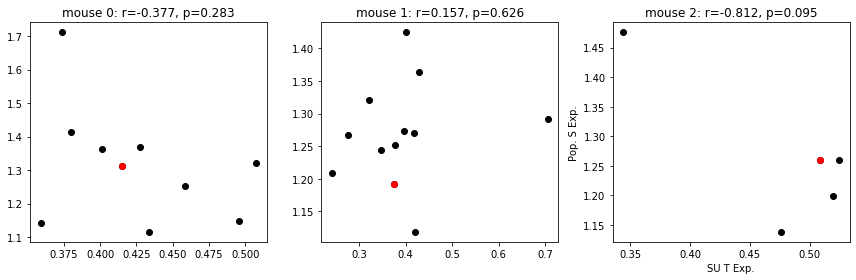

In [6]:
x_feat, y_feat = feats[0], feats[2]
plt.figure(figsize=(12,4))
for i_d, df_st_spectrum in enumerate(df_collect):
    plt.subplot(1,3,i_d+1)
    x, y = df_st_spectrum.loc[x_feat][val_regions[i_d]],df_st_spectrum.loc[y_feat][val_regions[i_d]]
    plt.plot(x,y,'ok')
    plt.plot(x['all'],y['all'],'or')
    plt.title('mouse %i: '%i_d+'r=%.3f, p=%.3f'%stats.pearsonr(x,y))

plt.xlabel(x_feat)
plt.ylabel(y_feat);
plt.tight_layout()

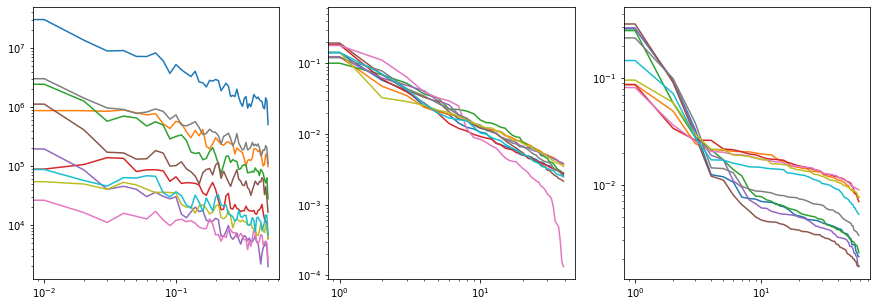

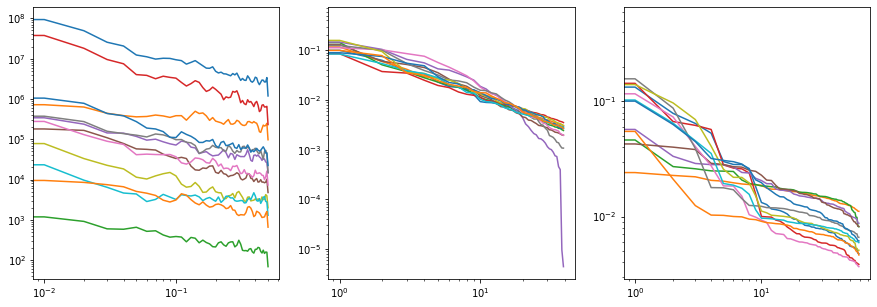

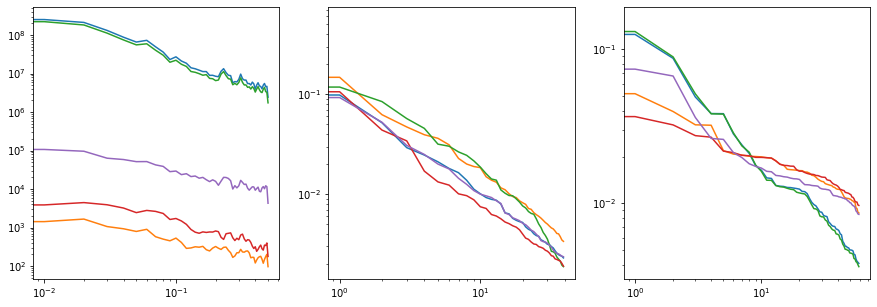

In [7]:
for i_m in range(len(mice)):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.loglog(faxis, psd_all[i_m][val_regions[i_m],:].T)
    plt.subplot(1,3,2)
    plt.loglog(pca_all[i_m][val_regions[i_m],:].T);
    plt.subplot(1,3,3)
    plt.loglog(ssa_all[i_m][val_regions[i_m],:].T);
    

In [395]:
[s.shape[1] for s in spk_list]

[134, 86, 155, 4, 4, 10, 10, 1878, 15]

Running FOOOFGroup across 10 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



(0.897208831657577, 0.0004307238862123373)

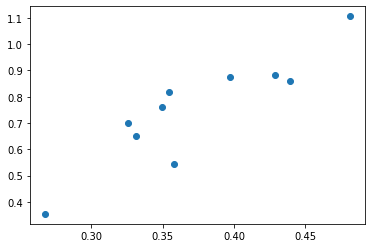

In [361]:
tau, dim = 5, 60
ssa_pool = []
for reg in df_spk.columns[:su_start_ind]:
#    print(reg)
    ssa = de.SSA(df_spk[reg].values, tau, dim)
    ssa_pool.append(ssa.explained_variance_ratio_)

ssa_pool = np.array(ssa_pool)
fg_ssa = FOOOFGroup(max_n_peaks=0)

ssa_fitrange = np.arange(10,40)
fg_ssa.fit(ssa_fitrange, ssa_pool[:, ssa_fitrange])
ssa_exp = fg_ssa.get_params('aperiodic_params', 'exponent')
x = ssa_exp
y = df_st_spectrum.loc[feats[1]][val_regions[i_m]]
plt.plot(x,y, 'o')
stats.pearsonr(x, y)

In [4]:
#set we are using
rSPCA_d = df_spk[df_spk.columns[su_start_ind:]] 

In [47]:
#A FOOOF Function, gets exponent parameters
def FOOOFy(components, spectra):
    fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed', verbose = False)
    fg.fit(components, spectra)
    m_array = fg.get_params('aperiodic_params', 'exponent')
    
    return m_array

#Decomposition in space
def PCAonData(subset, n_pc):
    pop_pca = PCA(n_pc).fit(subset)
    evals = pop_pca.explained_variance_ratio_
    
    return evals

#Decomposition in time
def ftOnData(subset):
    summed_neurons = subset.sum(axis= 1) # copying df for ft decomp.
    freqs, powers = compute_spectrum(summed_neurons, fs=1, nperseg=200, noverlap=50)
    powers = powers[None,:] 
    
    return freqs, powers

def randomSubsetDecomp(data, subset_size, n_iter, n_pc = None, verbose = False):
    if n_pc == None:
        n_pc = subset_size
        
    evals_mat = np.zeros((n_iter, n_pc)) # n_iter * |evals|
    powers_mat = np.zeros((n_iter, subset_size+1)) 
    freqs_mat = np.zeros((n_iter, subset_size+1)) # n_iter * |evals|
    
    for i in np.arange(n_iter):
        loc_array = np.random.choice(data.shape[1], subset_size)
        subset = data[loc_array]
        
        # decomposition in space
        evals = PCAonData(subset, n_pc)               
        evals_mat[i] = evals
        
        # decomposition in time
        freqs, powers = ftOnData(subset)
        powers_mat[i] = powers
        freqs_mat[i] = freqs
        
    pc_m_array = FOOOFy(np.arange(1,n_pc+1), evals_mat)
    ft_m_array = FOOOFy(freqs_mat[0], powers_mat)
    
    
    avg_pc_slope = np.mean(pc_m_array)
    avg_ft_slope = np.mean(ft_m_array)
    
    if verbose == True:
        
        print('Avg Space Decomposition slope:', np.mean(pc_m_array))
        print('Avg Time Decomposition slope:', np.mean(ft_m_array))
    
        plt.hist(pc_m_array)
        plt.title('Space Decomp')
        #plt.title('n_subset = ', subset_size)
        plt.figure()
        plt.hist(ft_m_array)
        plt.title('Time Decomp')
        plt.plot()
    
    
    return pc_m_array, avg_pc_slope, ft_m_array, avg_ft_slope

Running FOOOFGroup across 200 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 200 power spectra.
Avg Space Decomposition slope: 1.183526529222067
Avg Time Decomposition slope: 1.0859880468857532


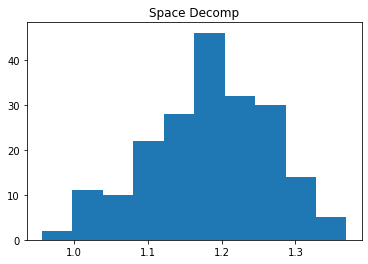

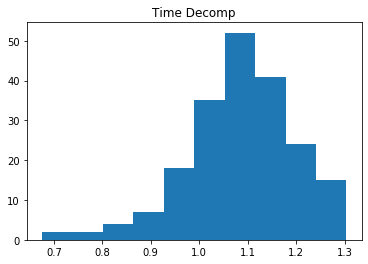

In [6]:
pc, ft = randomSubsetDecomp(rSPCA_d, 100, 200, n_pc = 30)

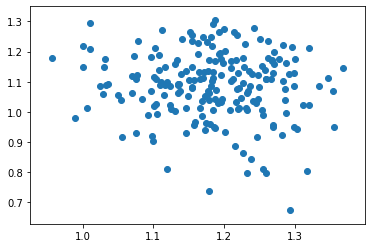

In [9]:
plt.scatter(pc,ft)

In [49]:
def Ramsey(data):
    n = 20 
    
    size = np.arange(0,n)
    eigs = np.zeros((n, n))
    powers = np.zeros((n, n))
    
    corr_coeffs = np.zeros((1, n))
    
    for i in size:
        pc, µp, ft, µf = randomSubsetDecomp(data, 100, n, n_pc = 30)
        
        eigs[i] = pc
        powers[i] = pc
        corr_coeffs[0][i] = np.corrcoef(pc,ft)[0][1]


    return eigs, powers, corr_coeffs

In [50]:
e, p, c = Ramsey(rSPCA_d)

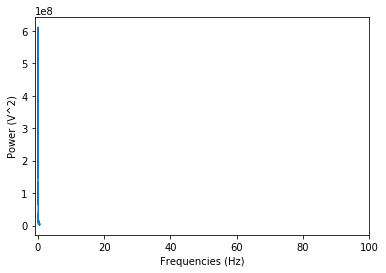

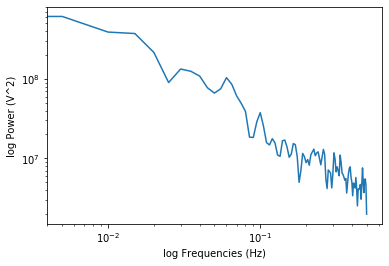

In [33]:
sn = rSPCA_d.sum(axis= 1) # copying df for ft decomp.
freqs, powers = compute_spectrum(sn, fs=1, nperseg=200, noverlap=50)

# fs = 1000
# freqs = np.fft.fftfreq(len(sn),1/fs)

# fft = np.fft.fft(sn/fs)
# powers = np.abs(fft)
plt.plot(freqs, powers)
plt.xlabel('Frequencies (Hz)');plt.ylabel('Power (V^2)');
plt.xlim([-1,100])
plt.figure()
plt.loglog(freqs, powers)
plt.xlabel('log Frequencies (Hz)');plt.ylabel('log Power (V^2)');

In [22]:
fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed')
fg.fit(freqs, powers[None,:])
m_array=fg.get_params('aperiodic_params', 'exponent')



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.45 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



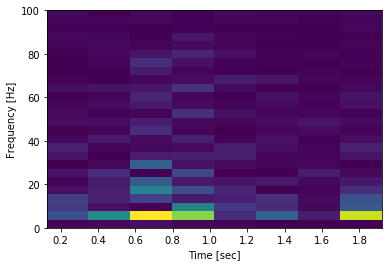

In [158]:
f, t, Sxx = signal.spectrogram(sn, 1000)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,100])
plt.show()

In [8]:
rSPCA_d = df_spk[df_spk.columns[su_start_ind:]] #set we are using

def randomSubsetPCA(data, subset_size, n_iter, n_pc = None):
    if n_pc == None:
        n_pc = subset_size
        

    evals_mat = np.zeros((n_iter, n_pc)) # n_iter * |evals|
    
    
    for i in np.arange(n_iter):
        loc_array = np.random.choice(data.shape[1], subset_size)
        subset = data[loc_array]
        
        # decomposition in space
        
        pop_pca = PCA(n_pc).fit(subset)
        evals = pop_pca.explained_variance_ratio_                
        evals_mat[i] = evals
        
      
    
    
    #PCA FOOOF
    
    fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed')
    fg.fit(np.arange(1,n_pc+1), evals_mat)
    m_array=fg.get_params('aperiodic_params', 'exponent')
        

    
    print('Avg slope:', np.mean(m_array))
    plt.hist(m_array)
#    plt.title('n_subset = ', subset_size)
#    plt.plot()
    return evals_mat, m_array

Running FOOOFGroup across 200 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Avg slope: 1.1968289571912047


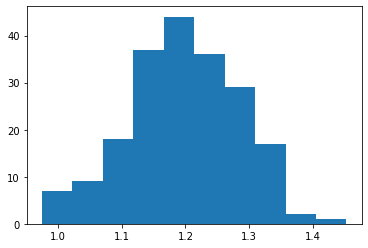

In [9]:
evals, slopes = randomSubsetPCA(rSPCA_d, 100, 200, n_pc = 30)

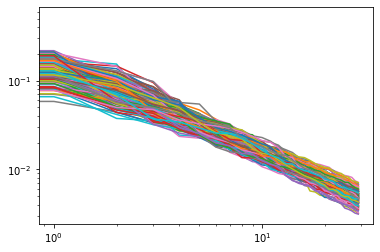

In [38]:
plt.loglog(evals.T);

In [14]:
n_pcs=20
n_trials=5
fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed')
fg.fit(np.arange(1,n_pc+1), np.random.randint(1, 100, size=(n_trials,n_pcs)))
fg.get_params('aperiodic_params', 'exponent')

Running FOOOFGroup across 5 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



array([-0.45801181,  0.10599444, -0.67944718,  0.74601427,  0.12853964])